**Training a Neural Network**
- Feed input data
- Initialize model parameters
- Perform forward and backward pass
- Update weights based on computed gradients
- Model checkpoints

**`mod`** (module) - Provides interfaces for executing predefined networks

**[Module API](https://mxnet.incubator.apache.org/api/python/module.html)**

**`module` usage by training a Multilayer Perceptron (MLP) on UCI Letter Recognition dataset**

In [1]:
import logging
logging.getLogger().setLevel(logging.INFO)
import mxnet as mx
import numpy as np

In [2]:
# Get data
fname = 'http://archive.ics.uci.edu/ml/machine-learning-databases/letter-recognition/letter-recognition.data'
data_file = mx.test_utils.download(fname)
data = np.genfromtxt(fname, delimiter=',')[:,1:]
label = np.array([ord(l.split(',')[0])-ord('A') for l in open(data_file, 'r')])

INFO:root:letter-recognition.data exists, skipping download


In [3]:
# MLP inputs
batch_size = 32
ntrain = int(data.shape[0]*0.8) # 80% train
train_iter = mx.io.NDArrayIter(data=data[:ntrain, :], label=label[:ntrain], 
                               batch_size=batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(data=data[ntrain:, :], label=label[ntrain:], 
                               batch_size=batch_size)

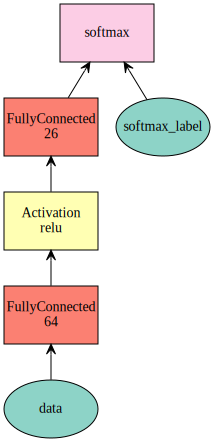

In [4]:
# Define the network
net = mx.sym.Variable('data')
net = mx.sym.FullyConnected(data=net, name='fc1', num_hidden=64)
net = mx.sym.Activation(data=net, name='relu1', act_type='relu')
net = mx.sym.FullyConnected(data=net, name='fc2', num_hidden=26)
net = mx.sym.SoftmaxOutput(data=net, name='softmax')
mx.viz.plot_network(net)

### Creating a Module

Construct a **`module`** by specifying the following parameters
- symbol - Network definition
- context - Device(s) to use for execution
- data_names - List of input data variable names
- label_names - List of input label variable names

In [5]:
# Arguments, inputs and outputs
print 'Arguments: ', net.list_arguments()
print 'Inputs: ', net.list_inputs()
print 'Outputs: ', net.list_outputs()

Arguments:  ['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'softmax_label']
Inputs:  ['data', 'fc1_weight', 'fc1_bias', 'fc2_weight', 'fc2_bias', 'softmax_label']
Outputs:  ['softmax_output']


In [6]:
# Construct a module
mod = mx.mod.Module(symbol=net, 
                    context=mx.cpu(), 
                    data_names=['data'], 
                    label_names=['softmax_label'])

### Intermediate-level Interface  

Training and inference using modules intermediate-level API's. To train a module followin steps need to be performed:

- **bind** - Prepares environment for computation by allocating memory
- **init_params** - Assigns and initializes parameter
- **init_optimizer** - Initializes optimizer (Default: SGD)
- **metric.create** - Creates evaluation metric from input metric name
- **forward** - Forward computation
- **update_metric** - Evaluates and accumulates evaluation metric on output of last forward computation
- **backward** - Backward computation
- **update** - Update parameters according to the installed optimizer and the gradients computed in the previous forward-backward batch

In [8]:
# Allocate memory given the input data and label shapes
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)

# Initialize parameters by uniform random numbers
mod.init_params(initializer=mx.init.Uniform(scale=0.1))

# Use SGD with learning rate 0.1 to train
mod.init_optimizer(optimizer='sgd', optimizer_params=(('learning_rate', 0.1),))

# Use accuracy as the metric
metric = mx.metric.create('acc')

# Train 10 epochs (epoch: going over all data in one pass)
for epoch in range(10):
    # Reset iterator and metric
    train_iter.reset()
    metric.reset()
    for batch in train_iter:
        # Forward pass and compute predictions
        mod.forward(batch, is_train=True)
        # Accumulate prediction accuracy
        mod.update_metric(metric, batch.label)
        # Compute gradients
        mod.backward()
        # Update parameters
        mod.update()
    print('Epoch: {} -- Training Metric: {}'.format(epoch, metric.get()))

Epoch: 0 -- Training Metric: ('accuracy', 0.4655625)
Epoch: 1 -- Training Metric: ('accuracy', 0.6635)
Epoch: 2 -- Training Metric: ('accuracy', 0.71725)
Epoch: 3 -- Training Metric: ('accuracy', 0.751375)
Epoch: 4 -- Training Metric: ('accuracy', 0.7750625)
Epoch: 5 -- Training Metric: ('accuracy', 0.7909375)
Epoch: 6 -- Training Metric: ('accuracy', 0.8080625)
Epoch: 7 -- Training Metric: ('accuracy', 0.8185625)
Epoch: 8 -- Training Metric: ('accuracy', 0.823625)
Epoch: 9 -- Training Metric: ('accuracy', 0.83575)


**High-level Interface**

- **`fit`**
- [Evaluation Metrics](https://mxnet.incubator.apache.org/api/python/metric.html)

In [9]:
# Reset train iter
train_iter.reset()

# Create a module
mod = mx.mod.Module(symbol=net, 
                    context=mx.cpu(), 
                    data_names=['data'], 
                    label_names=['softmax_label'])

# fit the module
mod.fit(train_data=train_iter, 
        eval_data=val_iter, 
        optimizer='sgd', 
        optimizer_params={'learning_rate': 0.1}, 
        eval_metric='acc', 
        num_epoch=10)

INFO:root:Epoch[0] Train-accuracy=0.382875
INFO:root:Epoch[0] Time cost=0.465
INFO:root:Epoch[0] Validation-accuracy=0.604500
INFO:root:Epoch[1] Train-accuracy=0.637563
INFO:root:Epoch[1] Time cost=0.498
INFO:root:Epoch[1] Validation-accuracy=0.681500
INFO:root:Epoch[2] Train-accuracy=0.701375
INFO:root:Epoch[2] Time cost=0.599
INFO:root:Epoch[2] Validation-accuracy=0.708750
INFO:root:Epoch[3] Train-accuracy=0.736125
INFO:root:Epoch[3] Time cost=0.524
INFO:root:Epoch[3] Validation-accuracy=0.731250
INFO:root:Epoch[4] Train-accuracy=0.764938
INFO:root:Epoch[4] Time cost=0.395
INFO:root:Epoch[4] Validation-accuracy=0.764000
INFO:root:Epoch[5] Train-accuracy=0.777188
INFO:root:Epoch[5] Time cost=0.497
INFO:root:Epoch[5] Validation-accuracy=0.757000
INFO:root:Epoch[6] Train-accuracy=0.795312
INFO:root:Epoch[6] Time cost=0.592
INFO:root:Epoch[6] Validation-accuracy=0.779750
INFO:root:Epoch[7] Train-accuracy=0.808688
INFO:root:Epoch[7] Time cost=0.460
INFO:root:Epoch[7] Validation-accuracy=0

In [10]:
# Predict and evaluate (validation set)
y = mod.predict(val_iter)
assert y.shape == (4000, 26)

In [11]:
# Predict (test set)
score = mod.score(eval_data=val_iter, eval_metric=['acc'])
print('Accuracy Score is {}'.format(score[0][1]))

Accuracy Score is 0.799
